<h1 style="text-align: center">KDD BR Competition 2018 - Final Solution</h1>
<br>
<p style="text-align: center">
    <a href="https://www.kaggle.com/gilbertoolimpio">Gilberto Olímpio Jr.</a>¹
</p>


<p style="text-align: center">
    ¹ Master's degree at the Federal University of Uberlândia
</p>

## Introduction

### Characteristics of the Palm Plant Production

Observing the best climatic characteristics for a good production of palm oil, the following was found [1]:
* Annual rainfall of at least 2000 mm spread evenly during the year;
* Mean maximum and minimum air temperatures of 29–33 ◦C and 22–24 ◦C respectively;
* Relative humidity >85%.

Thus it is possible that there is a significant correlation of these characteristics with the production of the plant.


## Libraries

In [1]:
#Systems libraries.
import datetime
import warnings
warnings.simplefilter("ignore")

# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
from matplotlib import pyplot as plt
import seaborn as sns


from scipy.stats import spearmanr

#Catboost to training model.
from catboost import CatBoostRegressor


## Analyzing datasets

### DataSet

In [2]:
#Loading a files of training, soil and test
training = pd.read_csv('./data/train.csv', index_col=[0])
soil_data = pd.read_csv('./data/soil_data.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
#offset in number of month, i.e. -6 six months in past
offset = -10

In [4]:
training.head()

,field,age,type,harvest_year,harvest_month,production
Id,,,,,,
0,0,19,5,2004,1,0.064071
1,0,19,5,2004,2,0.047658
2,0,19,5,2004,3,0.016866
3,0,19,5,2004,4,0.025525
4,0,19,5,2004,5,0.047690


In [5]:
soil_data.head()

,field,BDRICM_BDRICM_M,BDRLOG_BDRLOG_M,BDTICM_BDTICM_M,BLDFIE_sl1,BLDFIE_sl2,BLDFIE_sl3,BLDFIE_sl4,BLDFIE_sl5,BLDFIE_sl6,...,SLTPPT_sl5,SLTPPT_sl6,SLTPPT_sl7,SNDPPT_sl1,SNDPPT_sl2,SNDPPT_sl3,SNDPPT_sl4,SNDPPT_sl5,SNDPPT_sl6,SNDPPT_sl7
0,4,200,7,6973,1345,1308,1361,1413,1486,1503,...,21,19,20,47,48,47,42,40,40,39
1,3,200,9,7272,1297,1287,1323,1428,1492,1508,...,23,22,22,44,45,43,40,36,37,36
2,2,200,7,7281,1266,1249,1310,1387,1463,1491,...,21,21,22,46,46,45,40,39,39,39
3,1,200,6,7457,1297,1277,1345,1409,1480,1506,...,21,21,21,46,47,46,42,40,40,40
4,7,200,8,6771,1305,1289,1333,1438,1497,1510,...,22,21,22,44,45,44,40,38,38,37


In [6]:
test.head()

,Id,field,age,type,harvest_year,harvest_month
0,5243,0,27,5,2012,1
1,5244,0,27,5,2012,2
2,5245,0,27,5,2012,3
3,5246,0,27,5,2012,4
4,5247,0,27,5,2012,5


## Merge Files Function

For a better analysis a merge of the climate data files was performed. Thus the method receives an option to apply an "offset" in the dataset in order to analyze the climatic period equivalent to the production analyzes.

In [7]:
def merge_file(index_shift):
    
    #Merge function
    result_training = pd.merge(training, soil_data, on='field')
    result_test = pd.merge(test, soil_data, on='field')

    result_training['keys'] = result_training['field'].map(str) + result_training['harvest_year'].map(str) + result_training['harvest_month'].map(str)
    
    result_test['keys'] = result_test['field'].map(str) + result_test['harvest_year'].map(str) + result_test['harvest_month'].map(str)

    combine_training = pd.DataFrame()
    combine_test = pd.DataFrame()

    for f in range(0, 27):
        temp = pd.read_csv('./data/field-'+str(f)+'.csv')
        temp['field'] = f
        temp['keys'] = temp['field'].map(str) + temp['year'].map(str) + temp['month'].map(str)
        combine_training =  pd.concat([combine_training, temp])
        combine_test = pd.concat([combine_test, temp])

        
    combine_training.to_csv('./partial_results/climate_data.csv', index=True)
    
    result_training = pd.merge(result_training, combine_training, on='keys')
    result_test = pd.merge(result_test, combine_test, on='keys', how='left')

    result_test.sort_values(by=['Id'], ascending=True, inplace=True)

    #Execute a offset in dataset climate conditions
    #Precipitation
    result_training.Precipitation = result_training.Precipitation.shift(index_shift)
    result_test.Precipitation = result_test.Precipitation.shift(index_shift)

    #dewpoint
    result_training.dewpoint = result_training.dewpoint.shift(index_shift)
    result_test.dewpoint = result_test.dewpoint.shift(index_shift)

    #temperature
    result_training.temperature = result_training.temperature.shift(index_shift)
    result_test.temperature = result_test.temperature.shift(index_shift)

    #windspeed
    result_training.windspeed = result_training.windspeed.shift(index_shift)
    result_test.windspeed = result_test.windspeed.shift(index_shift)

    #Soilwater
    result_training.Soilwater_L1 = result_training.Soilwater_L1.shift(index_shift)
    result_test.Soilwater_L1 = result_test.Soilwater_L1.shift(index_shift)

    result_training.Soilwater_L2 = result_training.Soilwater_L2.shift(index_shift)
    result_test.Soilwater_L2 = result_test.Soilwater_L2.shift(index_shift)

    result_training.Soilwater_L3 = result_training.Soilwater_L3.shift(index_shift)
    result_test.Soilwater_L3 = result_test.Soilwater_L3.shift(index_shift)

    result_training.Soilwater_L4 = result_training.Soilwater_L4.shift(index_shift)
    result_test.Soilwater_L4 = result_test.Soilwater_L4.shift(index_shift)

    #Using fillna to fill in missing data
    result_test.fillna(result_test.mean(axis=0).astype(float), inplace=True)
    result_training.fillna(result_training.mean(axis=0).astype(float), inplace=True)

    #Removing repeated fields that will not be used                   
    result_training.drop(['BDRICM_BDRICM_M','keys','month','year', 'field_y'], axis=1)
    result_test.drop(['BDRICM_BDRICM_M','keys','month','year', 'field_y'], axis=1)

    #Setting ID field names
    result_training.rename(columns={'':'id'}, inplace=True)
    result_test.rename(columns={'Id':'id'}, inplace=True)

    
    #Merge results                   
    result_training.to_csv('./partial_results/merge_training.csv', index=True)
    result_test.to_csv('./partial_results/merge_test.csv', index=False)
        

### Executing a offset operation in dataset

The application of an "offset", is necessary, because according to the approach thought for the problem, the rainy period of 10 previous months implies directly in the production of the plant. For this reason, the climate data was shifted to represent the rainy season at the time of plant maturation.

In [8]:
#Execute a function for apply a merge and offset process.
merge_file(offset)

## Feature Selection

In [9]:
#Load merged files
test_df = pd.read_csv('./partial_results/merge_test.csv')
train_df = pd.read_csv('./partial_results/merge_training.csv')

Text(0.5,1,'Production Histogram')

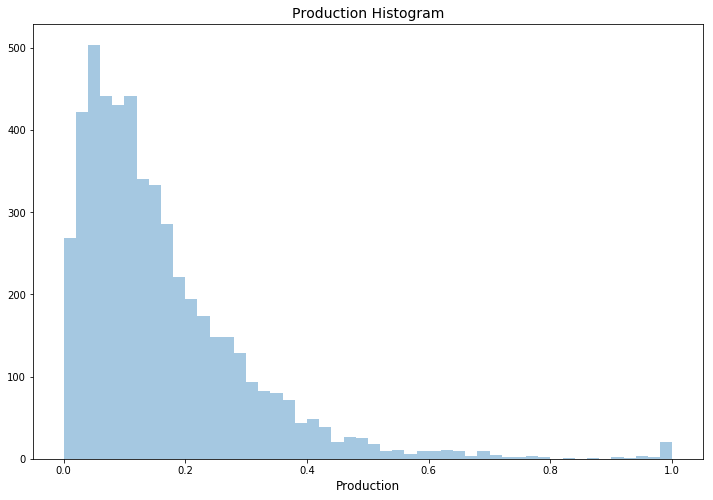

In [10]:
# Production Histogram
plt.figure(figsize=(12,8))
sns.distplot(train_df['production'].values, bins=50, kde=False)
plt.xlabel('Production', fontsize=12)
plt.title('Production Histogram', fontsize=14)

In [11]:
#Correlation: Preciptation, Temperature, Haverst Month and Production.
m = train_df.groupby('Precipitation').mean().reset_index()
m = train_df.groupby('temperature').mean().reset_index()
m = train_df.groupby('harvest_month').mean().reset_index()

print('Correlations: ')
print('Preciptation x Production: ', m['Precipitation'].corr(m['production']))
print('Temperature x Production: ', m['temperature'].corr(m['production']))
print('Harvest month x Production: ', m['harvest_month'].corr(m['production']))

Correlations: 
Preciptation x Production:  0.8249156215820402
Temperature x Production:  -0.48151249982531635
Harvest month x Production:  0.7295999965723176


Text(0.5,1,'Correlation coefficient of the variables')

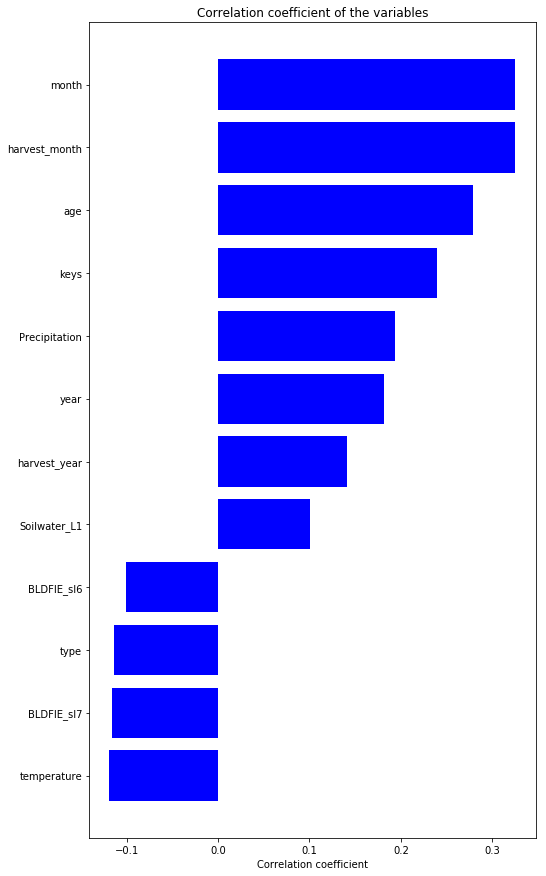

In [24]:
#Correlation coefficient of the variables
labels = []
values = []
for col in train_df.columns:
    if col not in ["id", "production"]:
        labels.append(col)
        values.append(spearmanr(train_df[col].values, train_df["production"].values)[0])
corr_df = pd.DataFrame({'col_labels': labels, 'corr_values': values})
corr_df = corr_df.sort_values(by='corr_values')

corr_df = corr_df[(corr_df['corr_values'] > 0.1) | (corr_df['corr_values'] < -0.1)]
ind = np.arange(corr_df.shape[0])
fig, ax = plt.subplots(figsize=(8, 15))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")

Text(0.5,1,'Important variables correlation map')

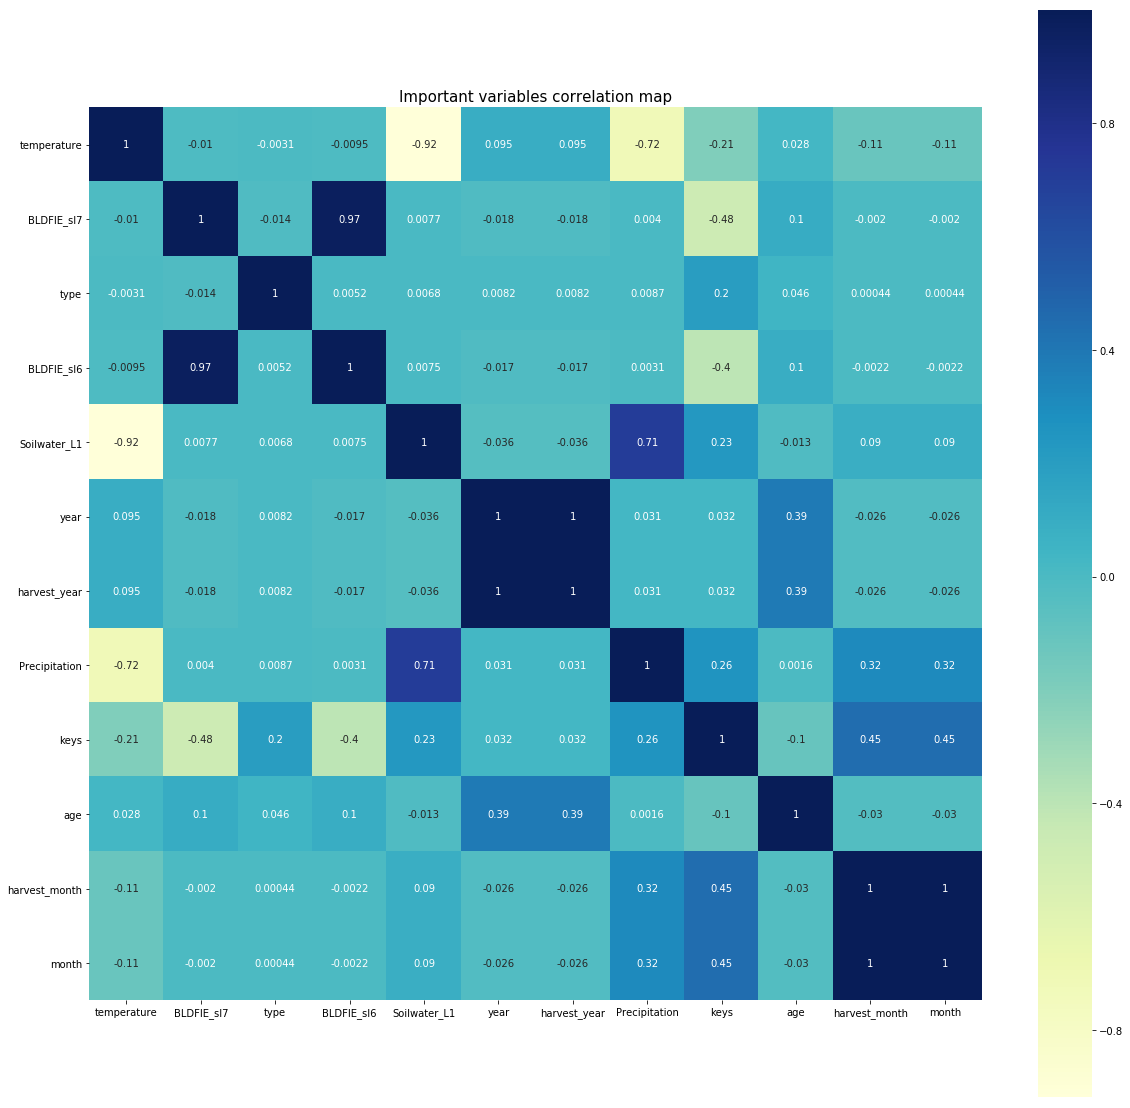

In [13]:
#Correlation Matrix
cols_to_use = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values']<-0.1)].col_labels.tolist()
temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("Important variables correlation map", fontsize=15)

Text(0.5,1,'Production Distribuition')

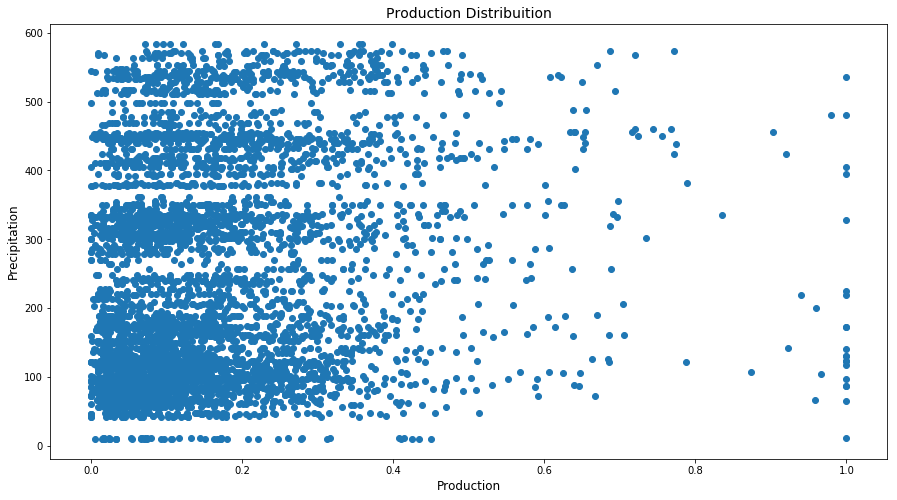

In [14]:
# Production Distribuition 
plt.figure(figsize=(15,8))
plt.scatter(train_df['production'].values, train_df.Precipitation)
plt.xlabel('Production',fontsize=12)
plt.ylabel('Precipitation', fontsize=12)
plt.title('Production Distribuition', fontsize=14)

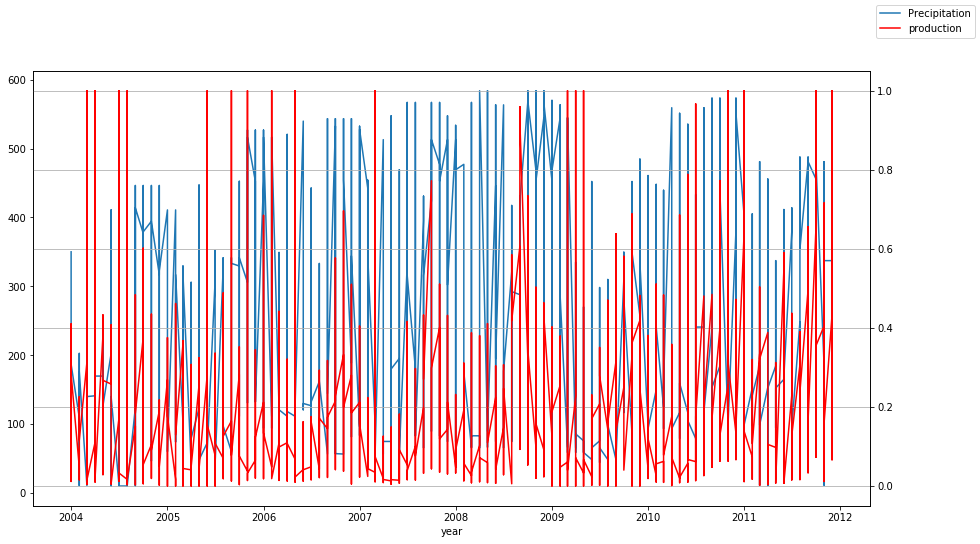

In [15]:
train_df['year'] = train_df.apply(lambda row: datetime.date(year=int(row['harvest_year']), month=int(row['harvest_month']), day=1),axis=1).values

ax = train_df.plot(x='year', y='Precipitation', legend=False, figsize=(15,8))
ax2 = ax.twinx()
train_df.plot(x='year', y='production', ax=ax2, legend=False, color="r", grid=True)
ax.figure.legend()

## Selection of features

From the analyzes made above, it is possible to determine which characteristics will be used for the training of the model.

In [16]:
df_params = ['age','type','harvest_year','harvest_month','BLDFIE_sl6', 'BLDFIE_sl7','temperature',
             'dewpoint','windspeed','Soilwater_L1','Soilwater_L2','Soilwater_L3','Soilwater_L4',
             'Precipitation','field_y']

In [17]:
X_train = train_df[df_params]
y_train = train_df['production']
X_test = test_df[df_params]

In [18]:
X_train.head()

,age,type,harvest_year,harvest_month,BLDFIE_sl6,BLDFIE_sl7,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,Soilwater_L3,Soilwater_L4,Precipitation,field_y
0,19,5,2004,1,1522,1535,26.328,24.753,1.9063,0.35677,0.35679,0.35697,0.36079,350.02,0
1,13,2,2004,1,1522,1535,26.566,24.940,1.8569,0.36002,0.36022,0.36085,0.36468,186.72,0
2,4,5,2004,1,1522,1535,26.566,24.940,1.8569,0.36002,0.36022,0.36085,0.36468,186.72,0
3,19,5,2004,2,1522,1535,26.077,24.373,1.8734,0.35241,0.35267,0.35274,0.35567,109.45,0
4,13,2,2004,2,1522,1535,26.077,24.373,1.8734,0.35241,0.35267,0.35274,0.35567,109.45,0


In [19]:
y_train.head()

0    0.064071
1    0.283228
2    0.106263
3    0.047658
4    0.182068
Name: production, dtype: float64

In [20]:
X_test.head()

,age,type,harvest_year,harvest_month,BLDFIE_sl6,BLDFIE_sl7,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,Soilwater_L3,Soilwater_L4,Precipitation,field_y
0,27,5,2012,1,1522,1535,29.815,21.118,2.4326,0.21182,0.21087,0.22919,0.25839,50.59,0.0
1,27,5,2012,2,1522,1535,27.974,22.671,2.3178,0.25850,0.25031,0.23437,0.24902,216.23,0.0
2,27,5,2012,3,1522,1535,26.395,24.069,2.3769,0.32757,0.32343,0.30735,0.26756,345.55,0.0
3,27,5,2012,4,1522,1535,26.246,24.051,2.3725,0.34441,0.34328,0.33941,0.32178,640.97,0.0
4,27,5,2012,5,1522,1535,26.561,24.571,2.3737,0.35250,0.35171,0.35012,0.34880,429.59,0.0


## Model

CatBoost is an open-source gradient boosting library. His choice is justified by both his tuning ability and his performance.
In this dispute was used CasBoostRegressor.
Compared to other models like the XGBRegressor or LGBMRegressor, CatBoostRegressor proved to be superior in performance to its ability to avoid overfiting.

In [21]:
cat = CatBoostRegressor(iterations=5, 
                        learning_rate=0.3, 
                        depth=6, 
                        loss_function='RMSE', 
                        verbose=False, 
                        l2_leaf_reg=7, 
                        random_state=6612349, 
                        border_count=220, 
                        od_type='Iter', 
                        feature_border_type='MaxLogSum', 
                        model_size_reg=100, 
                        leaf_estimation_iterations=20, 
                        leaf_estimation_method='Newton', 
                        metric_period=10, 
                        boosting_type='Ordered', 
                        bootstrap_type='Bayesian')

cat.fit(X_train, y_train, use_best_model=False)
prediction_cat = cat.predict(X_test)

### Preparing the file for submission

In [22]:
send = pd.DataFrame()
send['Id'] = test_df['id']
send['production'] = cat.predict(X_test)
send.to_csv('./send_final_result/send_result.csv', index=False)

### That's it! ;-)

# Reference

[1] Carr, M. K. V. (2011). The water relations and irrigation requirements of oil palm (Elaeis guineensis): a review. Experimental Agriculture, 47(4), 629-652.



CatBoost in https://tech.yandex.com/catboost/